In [2]:
#installing libraries
import sys
!{sys.executable} -m pip install pandas --user
!{sys.executable} -m pip install matplotlib --user
!{sys.executable} -m pip install scipy --user

  Using cached https://files.pythonhosted.org/packages/52/3f/f6a428599e0d4497e1595030965b5ba455fd8ade6e977e3c819973c4b41d/pandas-0.25.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d2/ab/43e678759326f728de861edbef34b8e2ad1b1490505f20e0d1f0716c3bf4/numpy-1.17.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e7/f9/f0b53f88060247251bf481fa6ea62cd0d25bf1b11a87888e53ce5b7c8ad2/pytz-2019.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/65/26/32b8464df2a97e6dd1b656ed26b2c194606c16fe163c695a992b36c11cdf/six-1.13.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/57/4f/dd381ecf6c6ab9bcdaa8ea912e866dedc6e696756156d8ecc087e20817e2/matplotlib-3.1.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached ht

In [73]:
!{sys.executable} -m pip install graphviz --user

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import collections
import numbers
from graphviz import Digraph

# Initial Conditions

In [2]:
S = 68.04
K = 67.50
σ = 0.2433
r = 0.0180
T= 173/365
δ = 0.0118

# Defining the Binomial Tree

In [64]:
import numpy as np

class Node:
    def __init__(self):
        self.S = 0
        self.Δ = 0
        self.B = 0
        self.C_American = 0
        self.P_American = 0
        self.C_European = 0
        self.P_European = 0

class BinomialModel:
    def __init__(self,S,δ,r,σ,K,T):
        self.S = S
        self.δ = δ
        self.r = r
        self.σ = σ
        self.K = K
        self.T = T
        N = st.norm.cdf
        ϕ = st.norm.pdf
        d1 = (np.log(S/K)+(r-δ+0.5*np.power(σ,2))*T)/(σ*np.sqrt(T))
        d2 = (np.log(S/K)+(r-δ-0.5*np.power(σ,2))*T)/(σ*np.sqrt(T))
        self.d1 = d1
        self.d2 = d2
        self.C_Eur = S*np.exp(-δ*T)*N(d1)-K*np.exp(-r*T)*N(d2)
        self.P_Eur = K*np.exp(-r*T)*N(-d2)-S*np.exp(-δ*T)*N(-d1)
        self.Δ_Call=np.exp(-δ*T)*N(d1)
        self.Δ_Put=-np.exp(-δ*T)*N(-d1)
        self.Γ_Call=(1.0/(S*self.σ*np.sqrt(T)))*np.exp(-δ*T)*ϕ(d1)
        self.Γ_Put=self.Γ_Call
        #Scaled by 1/100
        self.ν_Call=(S*np.exp(-δ*T)*ϕ(d1)*np.sqrt(T))/100.0
        self.ν_Put=self.ν_Call
        #Scaled by 1/365
        self.Θ_Call=(δ*S*np.exp(-δ*T)*N(d1)-r*K*np.exp(-r*T)*N(d2)-(σ/(2*np.sqrt(T)))*S*np.exp(-δ*T)*ϕ(d1))/365.0
        self.Θ_Put=(r*K*np.exp(-r*T)*N(-d2)-δ*S*np.exp(-δ*T)*N(-d1)-(self.σ/(2*np.sqrt(T)))*S*np.exp(-δ*T)*ϕ(d1))/365.0
        #Scaled 1/10,000
        self.ρ_Call=(T*K*np.exp(-r*T)*N(d2))/10000.0
        self.ρ_Put=(-T*K*np.exp(-r*T)*N(-d2))/10000.0
        #Scaled 1/10,000
        self.Ψ_Call=(-T*S*np.exp(-δ*T)*N(d1))/10000.0
        self.Ψ_Put=(T*S*np.exp(-δ*T)*N(-d1))/10000.0
        
        

    #creates recombining tree
    def getTree(self,periods,drift=True):
        levels = []
        prevlevel = []
        h = self.T/periods
        u = np.exp(( (self.r - self.δ)*h if drift else 0) + self.σ*np.sqrt(h))
        d = np.exp(((self.r - self.δ)*h if drift else 0) - self.σ*np.sqrt(h))
        p = (np.exp((self.r - self.δ)*h) - d)/(u - d)
        periods += 1
        for i in range(0,periods): #fill out bottom level
            node = Node()
            node.S = np.power(u,i)*np.power(d,(periods-i-1))*self.S
            node.C_European = max(0,node.S - self.K)
            node.P_European = max(0,self.K - node.S)
            node.C_American = node.C_European
            node.P_American = node.P_European
            prevlevel.append(node)
        levels.append(prevlevel)
        for i in range(1,periods): #start at the bottom
            level = []
            for j in range(0,periods-i):
                node = Node()
                node.S = prevlevel[j+1].S/u
                discount = np.exp(-self.r*h)
                node.C_European = discount*((1-p)*prevlevel[j].C_European + p*prevlevel[j+1].C_European)
                node.P_European = discount*((1-p)*prevlevel[j].P_European + p*prevlevel[j+1].P_European)
                node.C_American = discount*((1-p)*prevlevel[j].C_American + p*prevlevel[j+1].C_American)
                node.P_American = discount*((1-p)*prevlevel[j].P_American + p*prevlevel[j+1].P_American)
                node.C_American = max(node.C_American,node.S - self.K)
                node.P_American = max(node.P_American,self.K - node.S)
                node.Δ = np.exp(-self.δ*h)*(prevlevel[j+1].C_European - prevlevel[j].C_European)/(prevlevel[j+1].S - prevlevel[j].S)
                node.B = discount*(u*prevlevel[j].C_European - d*prevlevel[j+1].C_European)/(u-d)
                level.append(node)
            prevlevel = level
            levels.append(prevlevel)
        levels.reverse()
        print("h: ",h," u: ",u," d: ",d," p: ",p)
        return levels
    
    def getNodeProbabilities(self,periods,drift=True):
        h = self.T/periods
        u = np.exp(( (self.r - self.δ)*h if drift else 0) + self.σ*np.sqrt(h))
        d = np.exp(((self.r - self.δ)*h if drift else 0) - self.σ*np.sqrt(h))
        p = (np.exp((self.r - self.δ)*h) - d)/(u - d)
        #over complicated optimization using dynamic programming that is probably slower
        up = lambda l,i : l[i] if i<len(l) else 0
        down = lambda l,i : l[i] if i>=0 else 0
        probs = (lambda n,prev: probs(n+1,[p*up(prev,i) + (1-p)*down(prev,i-1) for i in range(0,n+1)]) if n <= periods else prev)
        prices = (lambda n,prev: prices(n+1,[d*prev[0] if i==0 else u*prev[i-1] for i in range(0,n+1)]) if n <= periods else prev)  
        return probs(1,[1.0]),prices(1,[self.S])
    
    
def renderTree(tree):
    dot = Digraph(edge_attr={"splines":"ortho"})
    edges = []
    for i in range(0,len(tree)):
        for j in range(0,len(tree[i])):
            ncurr = int(i*(i+1)/2)
            nnext = int((i+1)*(i+2)/2)
            dot.node(name=str(ncurr+j),
                     label=''.join([k+" = "+f"{v:.2f}"+"\n" for k,v in tree[i][j].__dict__.items()]),
                     shape="box")
            if i<len(tree)-1:
                edges+=[(str(ncurr+j),str(nnext+j)),(str(ncurr+j),str(nnext+j+1))]
    dot.edges(edges)
    return dot


In [65]:
model = BinomialModel(S,δ,r,σ,K,T)

In [61]:
pd.set_option("display.precision", 4)
pd.set_option('display.max_columns', 999)
pd.DataFrame.from_dict({k:[v] for k,v in model.__dict__.items()})

,S,δ,r,σ,K,T,d1,d2,C_Eur,P_Eur,Δ_Call,Δ_Put,Γ_Call,Γ_Put,ν_Call,ν_Put,Θ_Call,Θ_Put,ρ_Call,ρ_Put,Ψ_Call,Ψ_Put
0,68.04,0.0118,0.018,0.2433,67.5,0.474,0.1489,-0.0186,4.868,4.1341,0.5561,-0.4384,0.0344,0.0344,0.1838,0.1838,-0.0133,-0.0122,0.0016,-0.0016,-0.0018,0.0014


# Four Period

In [63]:
renderTree(model.getTree(1000))

h:  0.00047397260273972604  u:  1.0053138702738462  d:  0.9947200638991928  p:  0.49867578738286233


CalledProcessError: Command '['dot', '-Tsvg']' died with <Signals.SIGSEGV: 11>. [stderr: b'']

# Twenty Four Period American

h:  0.019748858447488585  u:  1.0349090470569835  d:  0.9665051423370736  p:  0.4914530569474449


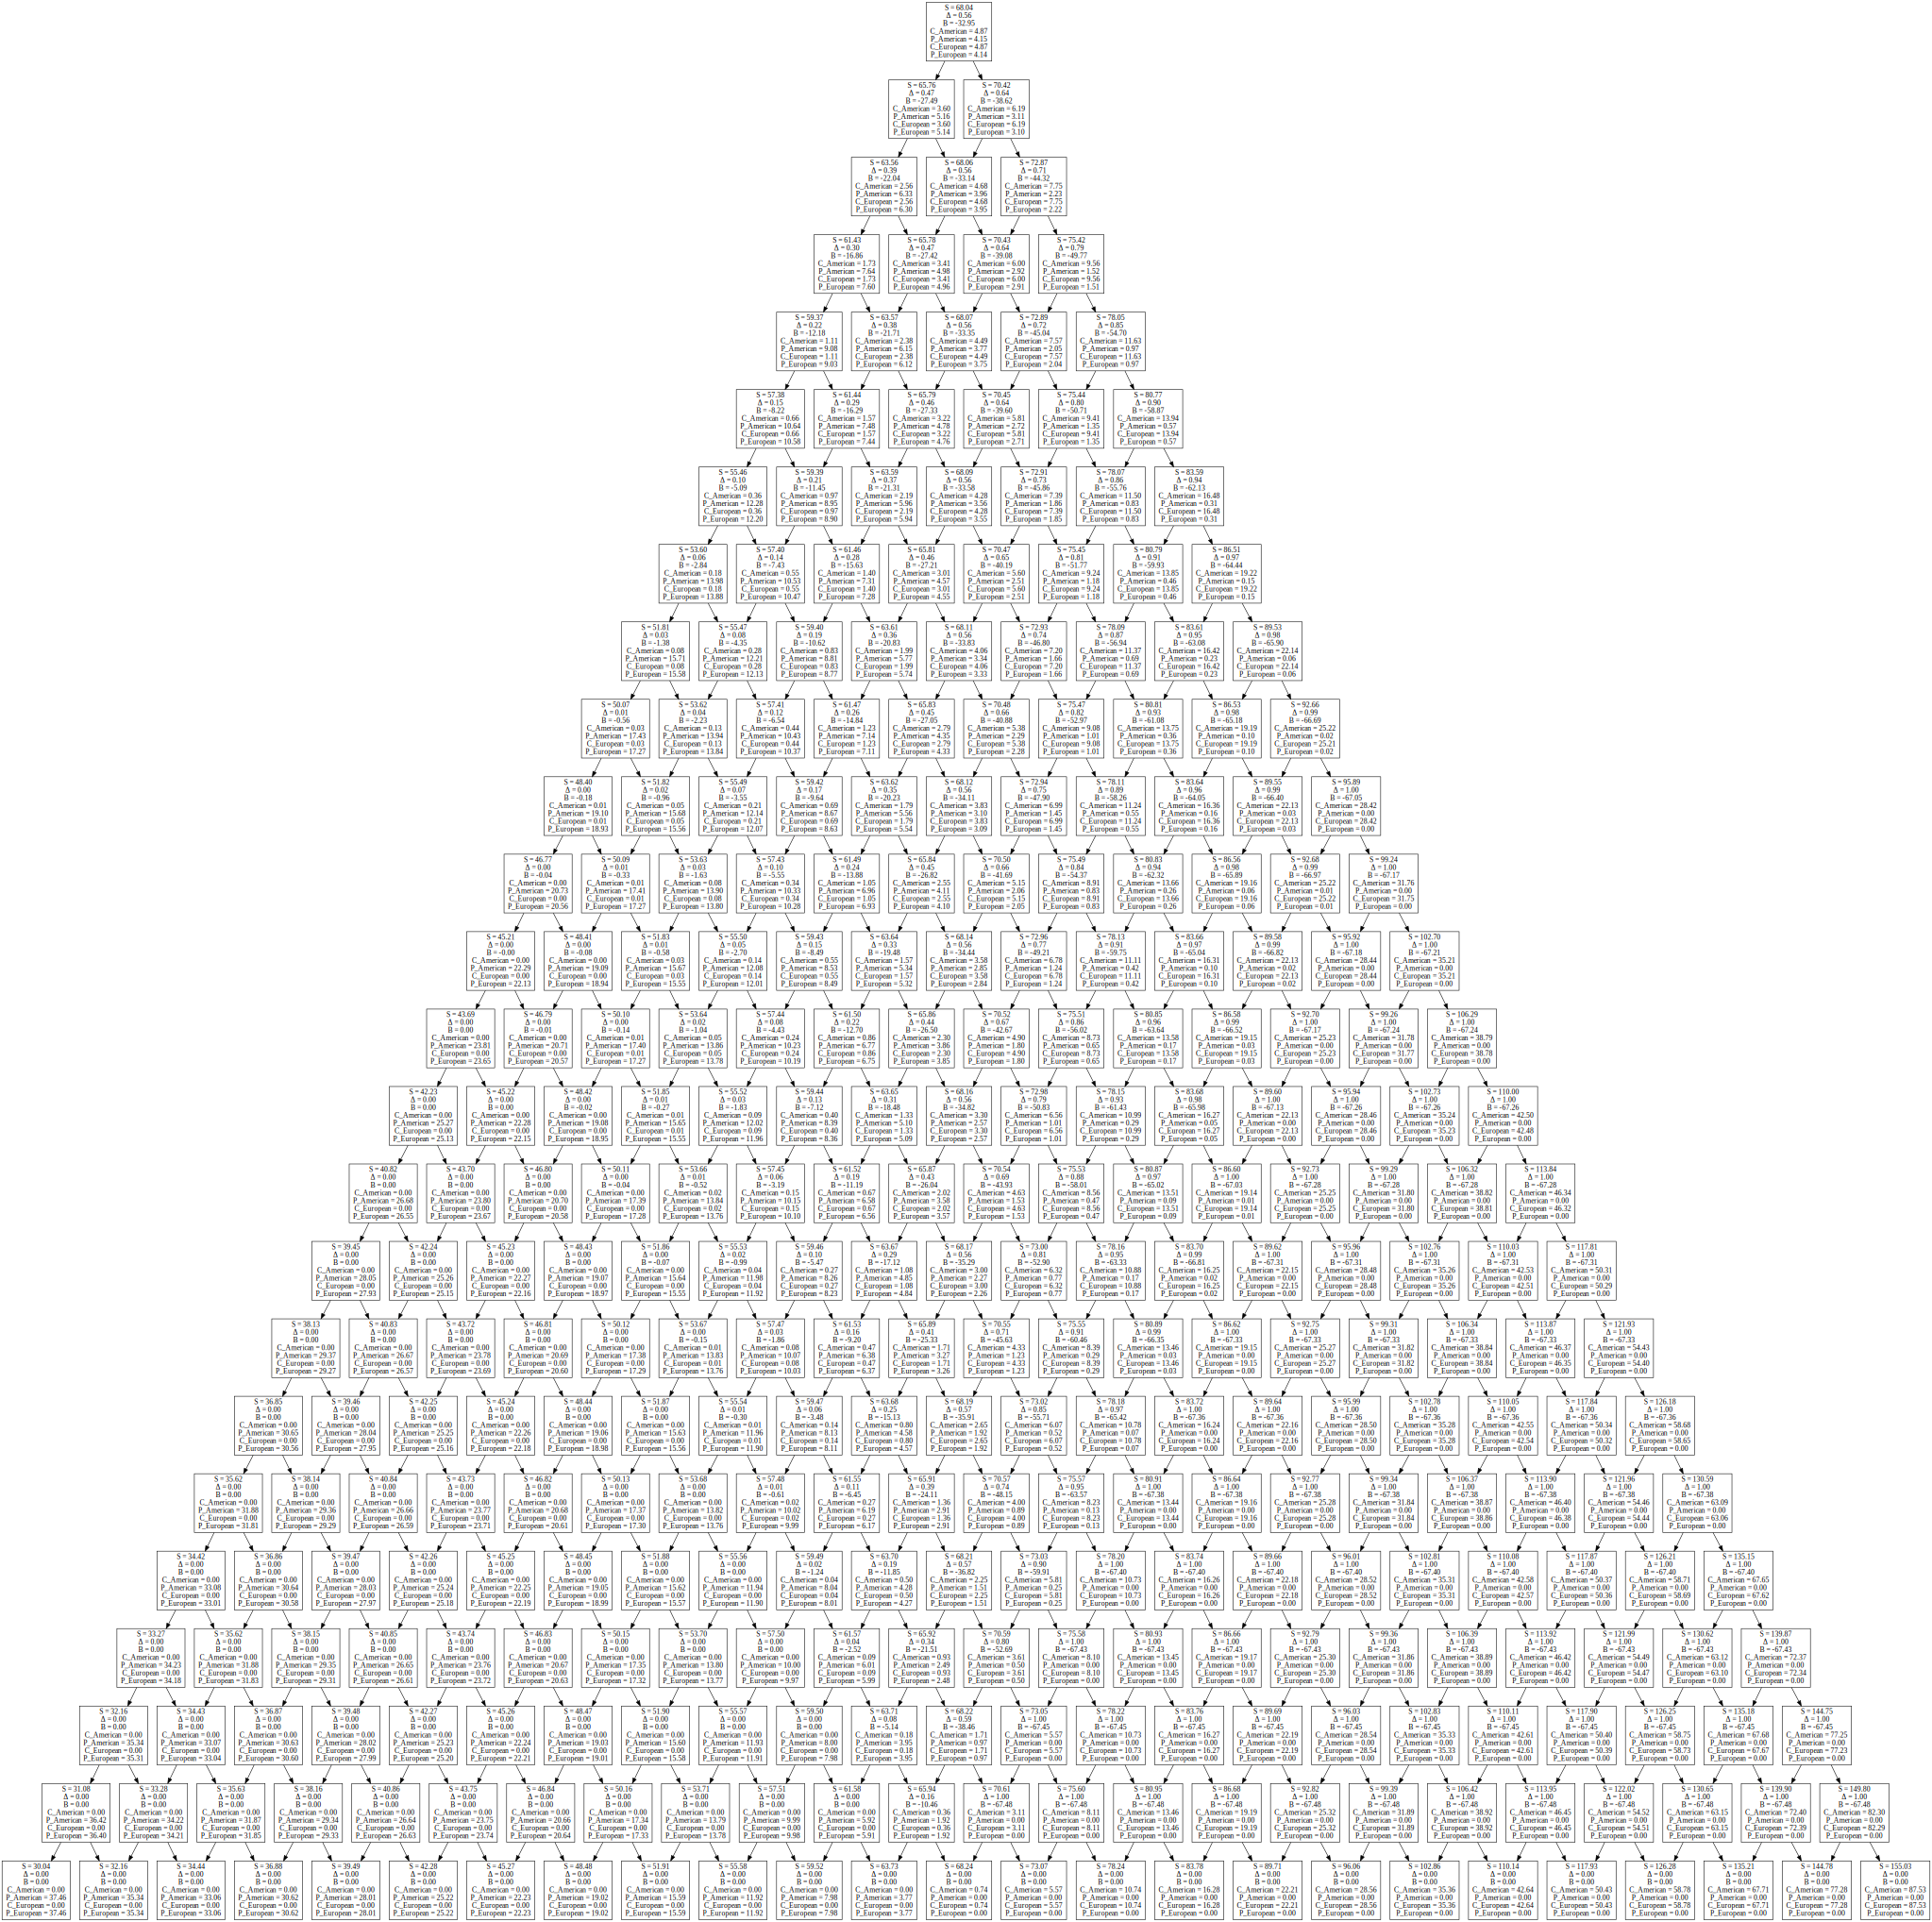

In [23]:
renderTree(model.getTree(24))

h:  0.019748858447488585  u:  1.0346392970243476  d:  0.9662532218476069  p:  0.49145305694744446


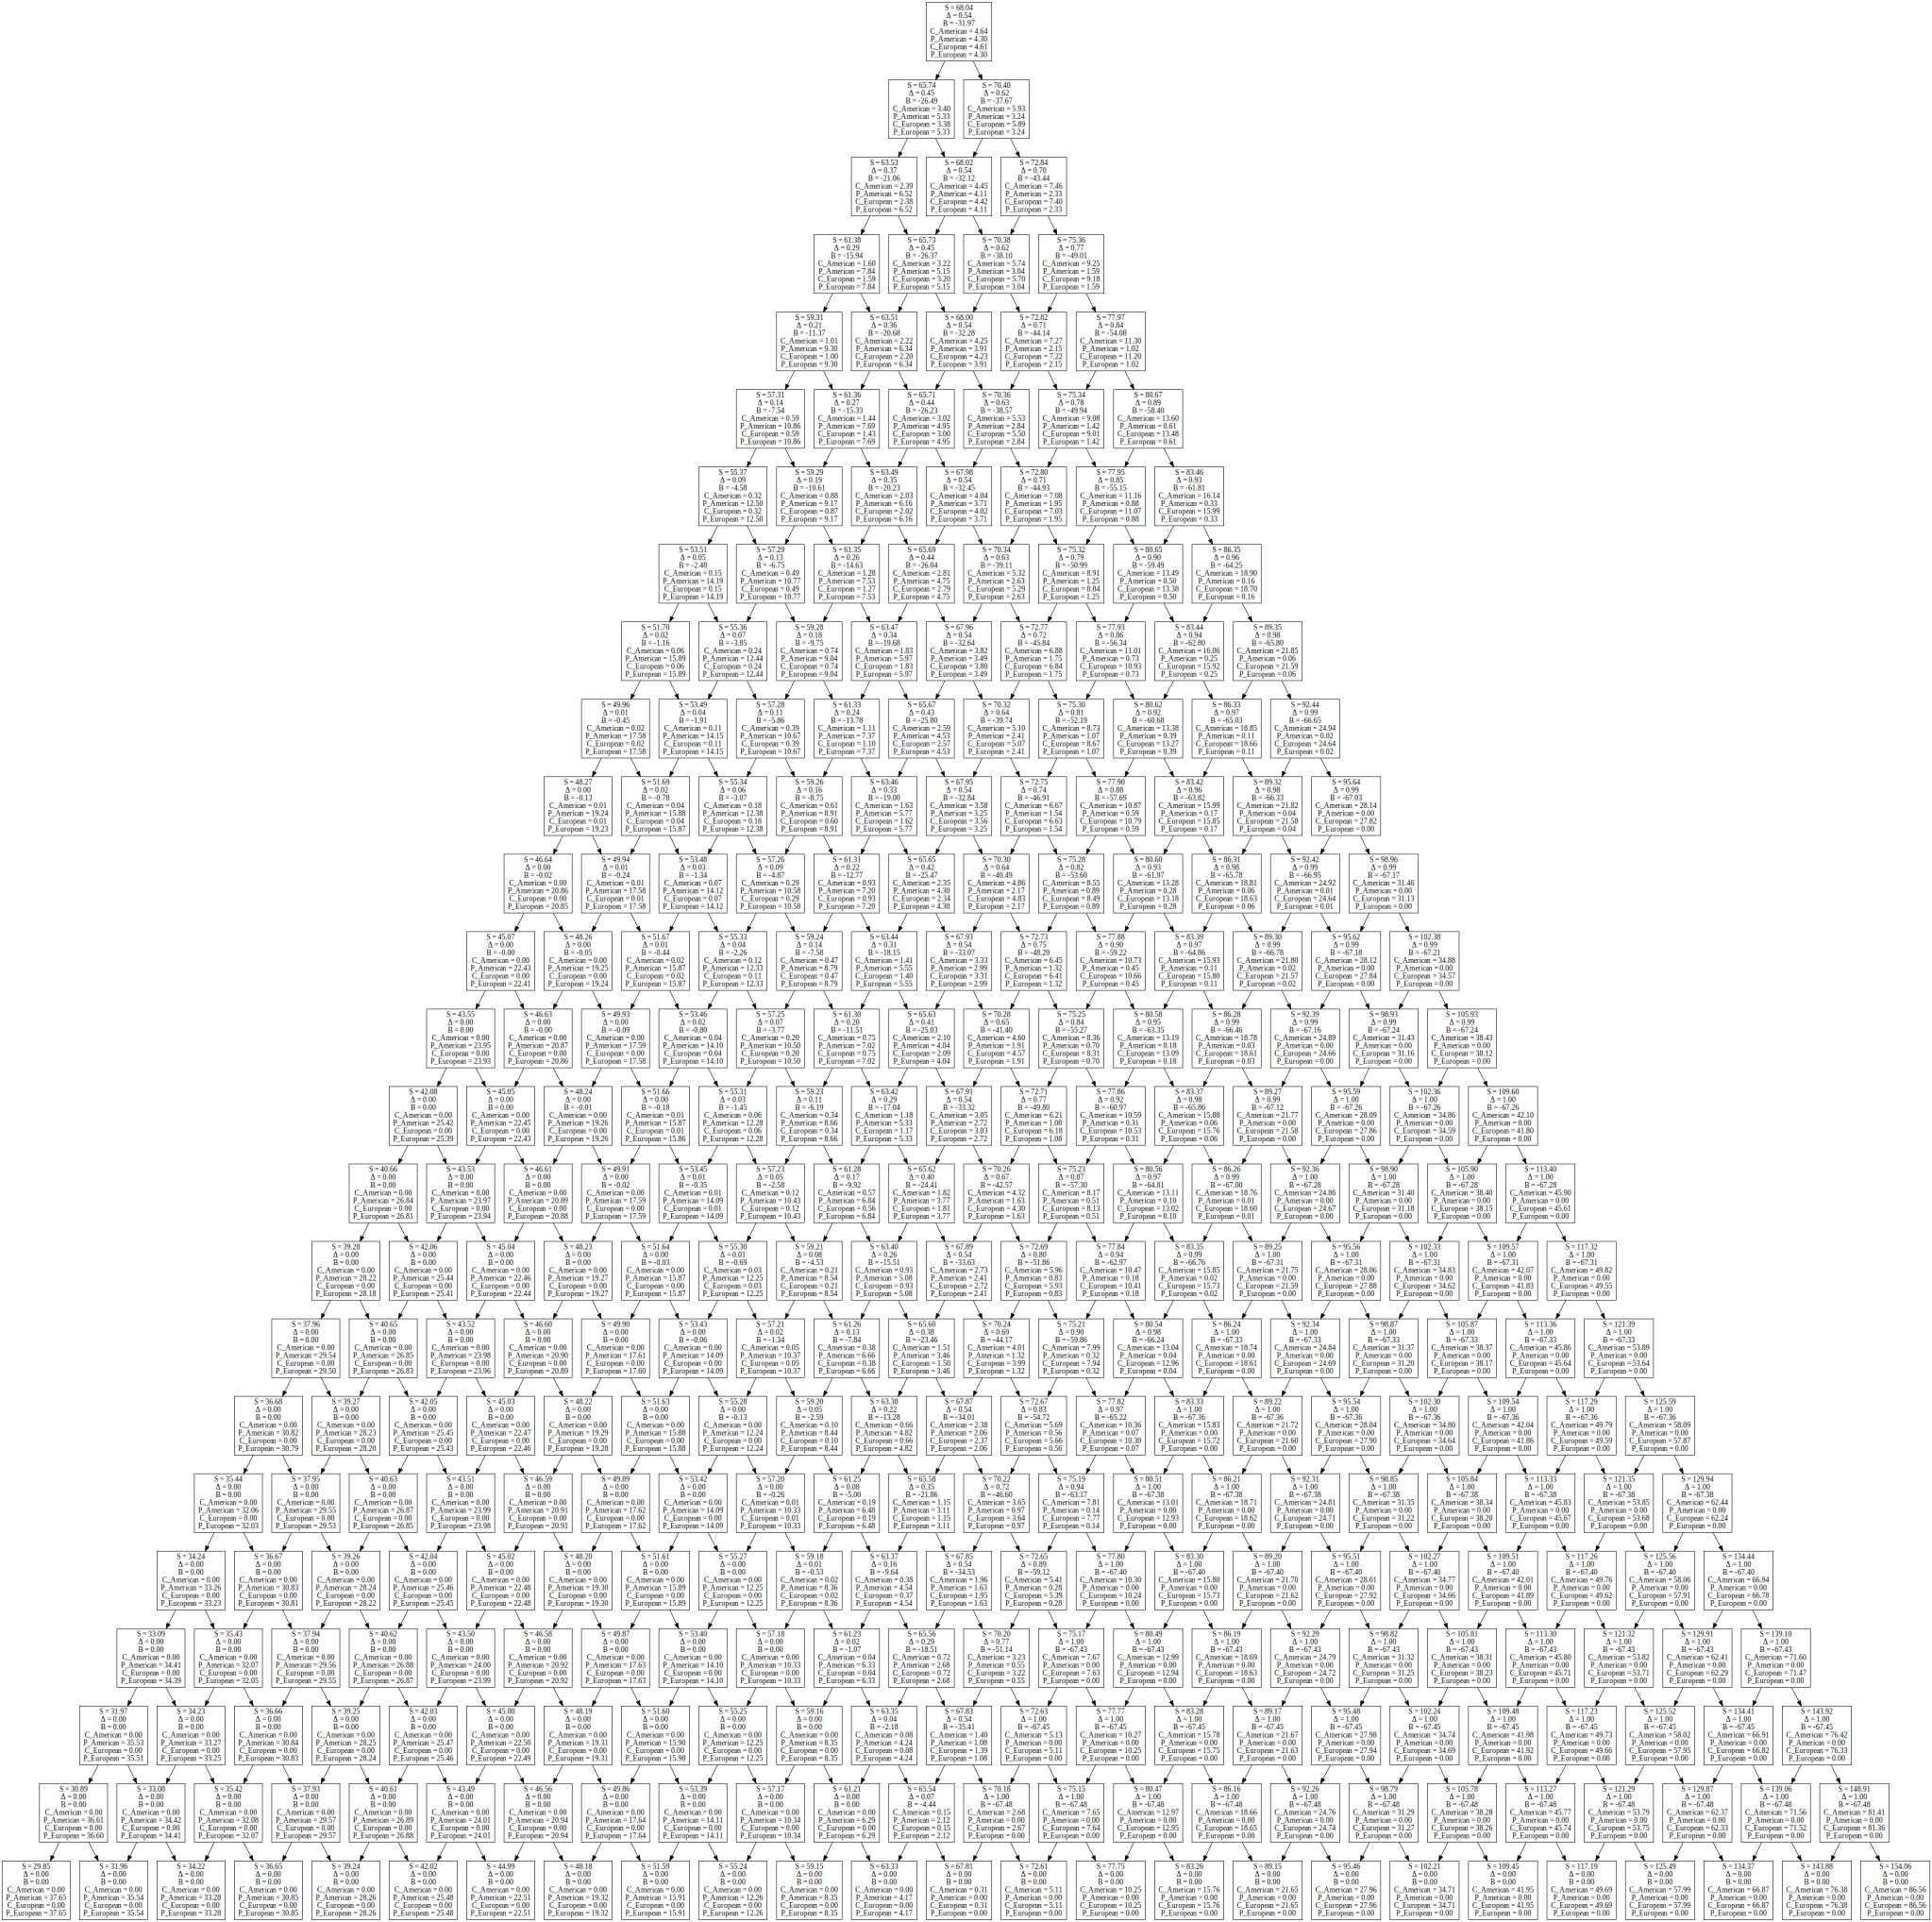

In [24]:
renderTree(BinomialModel(S,0.025,r,σ,K,T).getTree(24))

In [25]:
pd.set_option("display.precision", 4)
pd.set_option('display.max_columns', 999)
pd.DataFrame.from_dict({k:[v] for k,v in m.__dict__.items()})

NameError: name 'm' is not defined

h:  0.019748858447488585  u:  1.0350521248523712  d:  0.9666387631855816  p:  0.4914530569474427


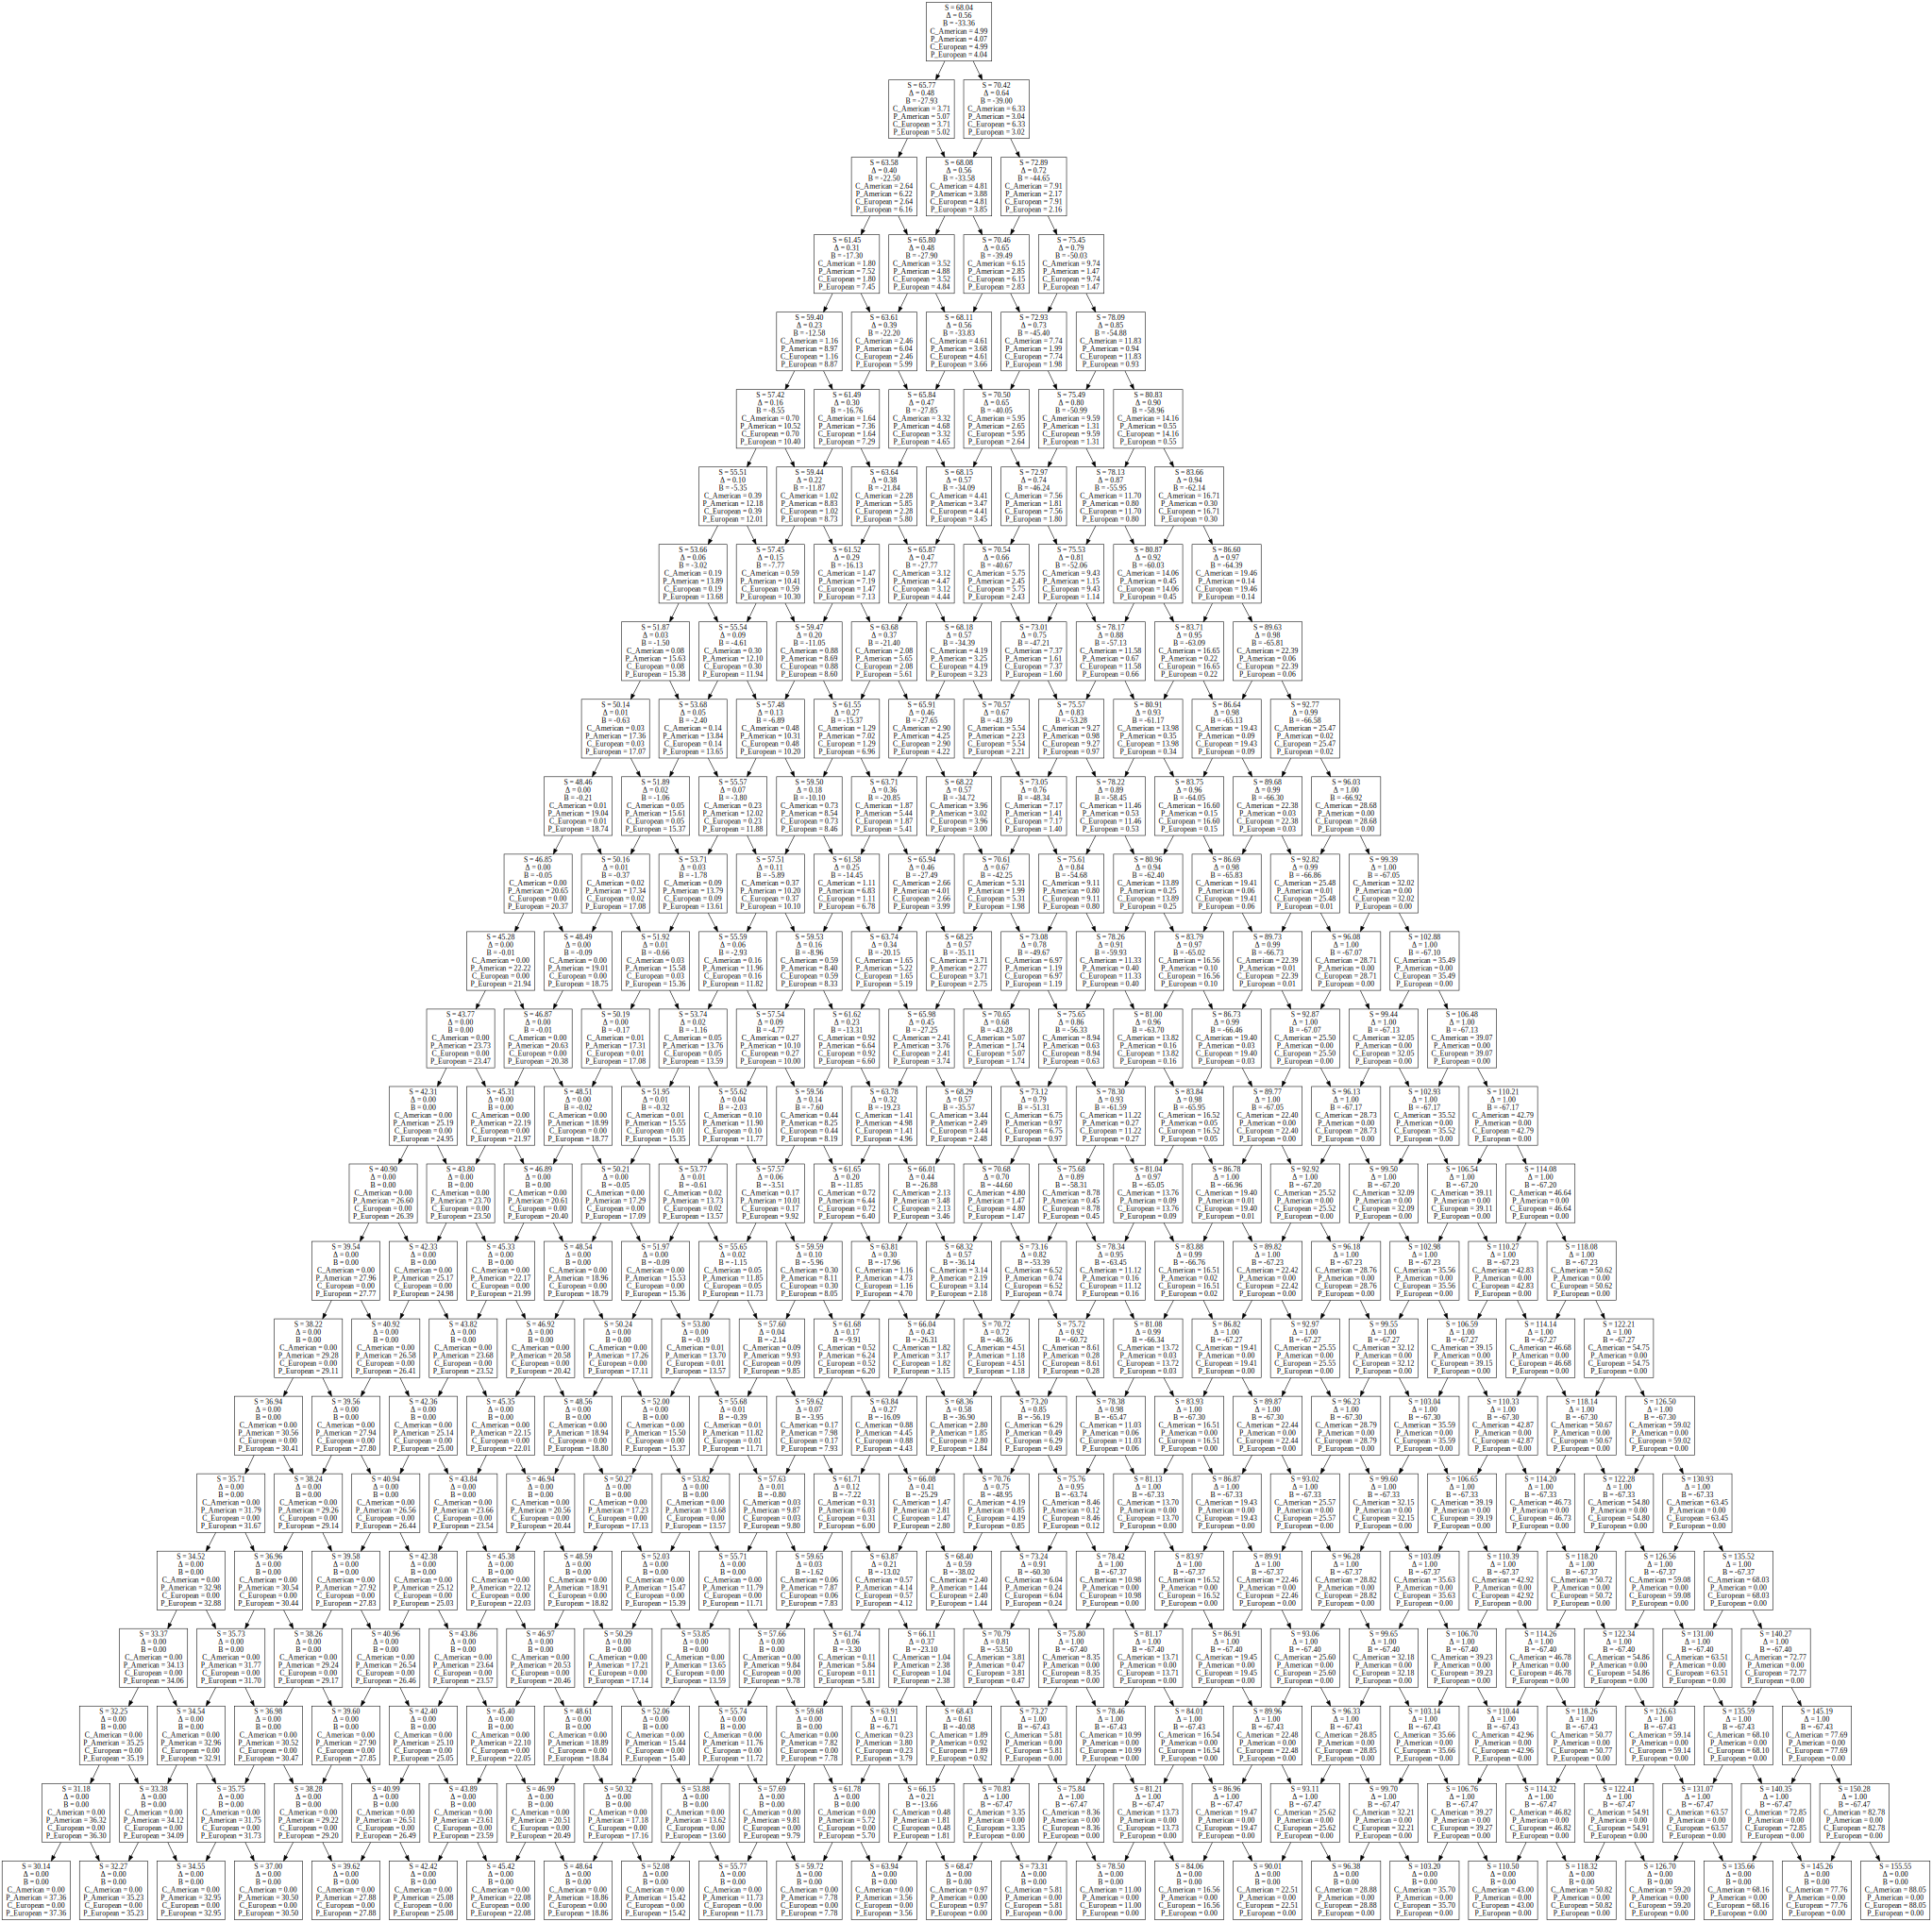

In [26]:
renderTree(BinomialModel(S,δ,0.025,σ,K,T).getTree(24))

# 24 Period American Call C-R-R

h:  0.019748858447488585  u:  1.0347823375263712  d:  0.9663868078677129  p:  0.4932433847572602


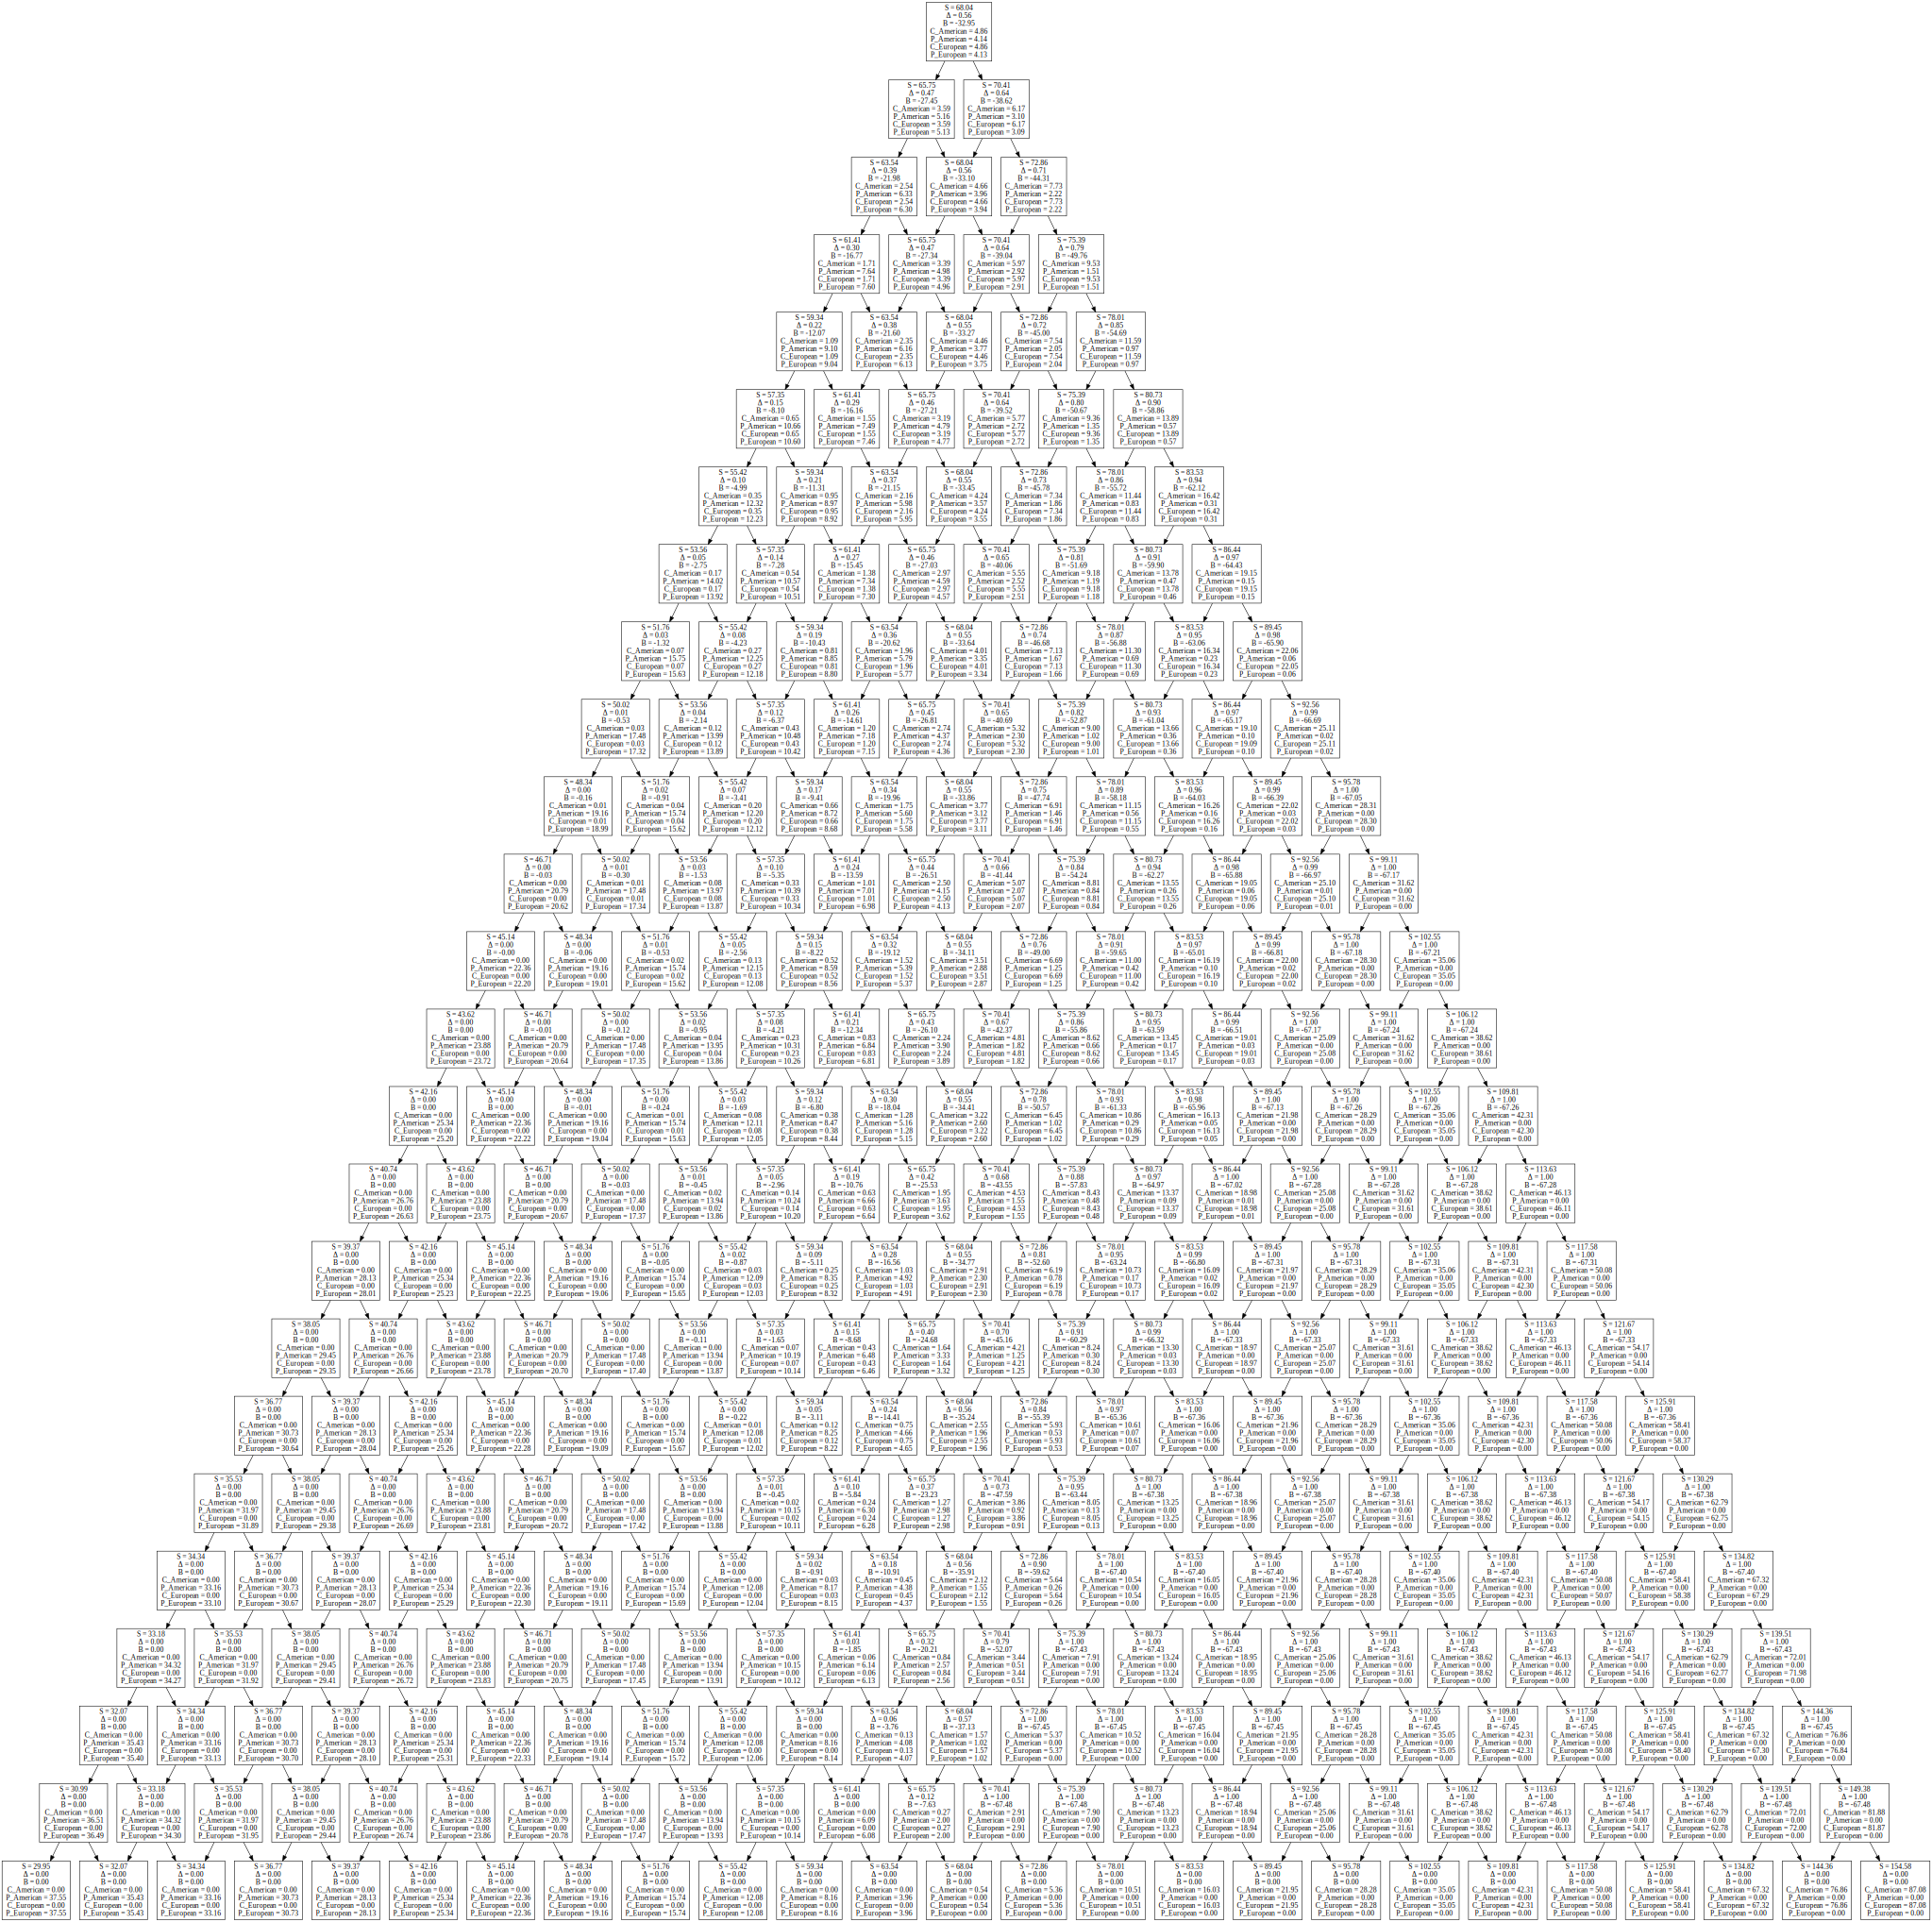

In [27]:
renderTree(model.getTree(24,drift=False))

[30.0375400084302, 32.163431464929616, 34.43978179667478, 36.87723965323383, 39.487207336875336, 42.28189414195074, 45.27437346934435, 48.47864398316905, 51.90969509579585, 55.583577087552506, 59.51747618910813, 63.729794977774645, 68.24023846381534, 73.06990626946764, 78.2413913318888, 83.77888559175189, 89.70829316189784, 96.05735150544062, 102.8557611901906, 110.13532482638067, 117.93009583763785, 126.27653776114524, 135.2136948221896, 144.78337458103599, 155.0303435065404]


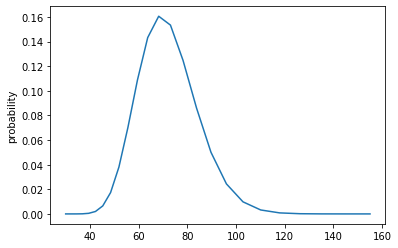

In [67]:
probabilities,prices = model.getNodeProbabilities(24)
print(prices)

import matplotlib.pyplot as plt
plt.plot(prices,probabilities)
plt.ylabel('probability')
plt.show()